## 加载 MNIST 数据集

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data('mnist.npz')

print(x_train.shape, type(x_train))
print(y_train.shape, type(y_train))

Using TensorFlow backend.


(60000, 28, 28) <class 'numpy.ndarray'>
(60000,) <class 'numpy.ndarray'>


## 数据处理：规范化

`channels_last` corresponds to inputs with shape  (batch, height, width, channels) while `channels_first` corresponds to inputs with shape  (batch, channels, height, width).

It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be `channels_last`.

In [2]:
from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(x_train.shape, type(x_train))
print(x_test.shape, type(x_test))

(60000, 28, 28, 1) <class 'numpy.ndarray'>
(10000, 28, 28, 1) <class 'numpy.ndarray'>


In [3]:
# 将数据类型转换为float32
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
# 数据归一化
X_train /= 255
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


## 统计训练数据中各标签数量

In [4]:
import numpy as np
import matplotlib.pyplot as plt

label, count = np.unique(y_train, return_counts=True)
print(label, count)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


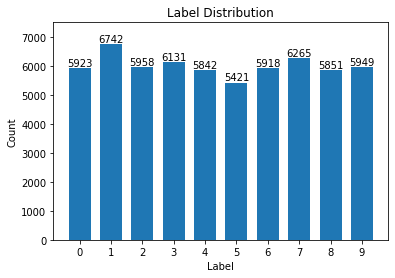

In [5]:
fig = plt.figure()
plt.bar(label, count, width=0.7, align='center')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(label)
plt.ylim(0, 7500)

for a, b in zip(label, count):
    plt.text(a, b, '%d' % b, ha='center', va='bottom', fontsize=10)

plt.show()

## 数据处理：one-hot 编码

### 几种编码方式的对比

| Binary | Gray code | One-hot  |
| ------ | --------- | -------- |
| 000    | 000       | 00000001 |
| 001    | 001       | 00000010 |
| 010    | 011       | 00000100 |
| 011    | 010       | 00001000 |
| 100    | 110       | 00010000 |
| 101    | 111       | 00100000 |
| 110    | 101       | 01000000 |
| 111    | 100       | 10000000 |

### one-hot 应用
![](https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2018/01/one-hot-word-embedding-vectors.png)

In [6]:
from keras.utils import np_utils

n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)
Y_test = np_utils.to_categorical(y_test, n_classes)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [7]:
print(y_train[0])
print(Y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 使用 Keras sequential model 定义 MNIST CNN 网络


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
# Feature Extraction
# 第1层卷积，32个3x3的卷积核 ，激活函数使用 relu
model.add(Conv2D(filters=32, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))

# 第2层卷积，64个3x3的卷积核，激活函数使用 relu
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# 最大池化层，池化窗口 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout 25% 的输入神经元
model.add(Dropout(0.25))

# 将 Pooled feature map 摊平后输入全连接网络
model.add(Flatten())

# Classification
# 全联接层
model.add(Dense(128, activation='relu'))

# Dropout 50% 的输入神经元
model.add(Dropout(0.5))

# 使用 softmax 激活函数做多分类，输出各数字的概率
model.add(Dense(n_classes, activation='softmax'))

## 查看 MNIST CNN 模型网络结构

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [10]:
for layer in model.layers:
    print(layer.get_output_at(0).get_shape().as_list())

[None, 26, 26, 32]
[None, 24, 24, 64]
[None, 12, 12, 64]
[None, 12, 12, 64]
[None, None]
[None, 128]
[None, 128]
[None, 10]


## 编译模型

[model.compile()](https://keras.io/models/sequential/#compile)

```python
compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
```

In [12]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')

## 训练模型，并将指标保存到 history 中

[model.fit()](https://keras.io/models/sequential/#fit)

```python
fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
```

In [13]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=128,  # 每一轮使用128个样本数据
                    epochs=5,  # 一共训练5轮
                    verbose=2,
                    validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 46s - loss: 0.2428 - accuracy: 0.9277 - val_loss: 0.0502 - val_accuracy: 0.9836
Epoch 2/5
 - 46s - loss: 0.0859 - accuracy: 0.9750 - val_loss: 0.0387 - val_accuracy: 0.9877
Epoch 3/5
 - 44s - loss: 0.0653 - accuracy: 0.9798 - val_loss: 0.0351 - val_accuracy: 0.9879
Epoch 4/5
 - 44s - loss: 0.0528 - accuracy: 0.9837 - val_loss: 0.0306 - val_accuracy: 0.9894
Epoch 5/5
 - 44s - loss: 0.0446 - accuracy: 0.9861 - val_loss: 0.0312 - val_accuracy: 0.9901


## 可视化指标

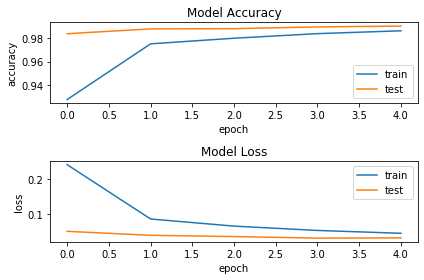

In [15]:
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

plt.show()

## 保存模型

[model.save()](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)

You can use `model.save(filepath)` to save a Keras model into a single **HDF5 file** which will contain:

- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

You can then use `keras.models.load_model(filepath)` to reinstantiate your model. load_model will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [16]:
import os

save_dir = "./mnist/model/"

model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./mnist/model/keras_mnist.h5 


## 加载模型

In [17]:
from keras.models import load_model

mnist_model = load_model(model_path)

## 统计模型在测试集上的分类结果

In [19]:
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)
    
print("Test Loss: {}".format(loss_and_metrics[0]))
print("Test Accuracy: {:.2f}%".format(loss_and_metrics[1]*100))

predicted_classes = mnist_model.predict_classes(X_test)

correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print("Classified correctly count: {}".format(len(correct_indices)))
print("Classified incorrectly count: {}".format(len(incorrect_indices)))

Test Loss: 0.031244982403610993
Test Accuracy: 99.01%
Classified correctly count: 9901
Classified incorrectly count: 99
